<a href="https://colab.research.google.com/github/jdmiranda/ai_notebooks/blob/master/outlier_removal_genetic_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier Removal GA

In [2]:
!pip install -q deap

    100% |████████████████████████████████| 942kB 19.6MB/s 


In [0]:
from time import time # for run times
import numpy as np # for cost computation
import random # for random number generation
from deap import base, creator, tools # deap used for genetic algorithm
import matplotlib.pyplot as plt # for figures
import pandas as pd # to save results

In [0]:
#dataDir = 'data/'
#fileList = ['outlier'+str(i)+'.txt' for i in range(1,16)]
dataDir = './'
fileList = ['outlier1.txt']

# Specify parameters for Genetic Algorithm

In [0]:
POPSIZE = 1000 # population size
NGEN = 1000 # number of generations
CXPB = 0.9 # crossover probability
MUTPB = 0.2 # mutation probability
INVPB = 0.02 # probability of inverting a bit
TSIZE = 3 # tournament size for selection

In [0]:
def readProblem(filename):
    """reads data from filename"""
    f = open(filename)
    c = float(f.readline()) # cost factor
    d = int(f.readline()) # dimensions
    n = int(f.readline()) # number of points
    points = {}
    for i in range(n):
        line = [int(v) for v in f.readline().split(',')]
        points[line[0]] = tuple(line[1:])
    f.close()
    return c, d, n, points

In [0]:
def sse(x):
    """Returns sum of squared deviation from mean of points in x"""
    return 0 if len(x)<=1 else len(x)*sum(np.var(x, axis=0))

In [0]:
def getPoints(individual, points, n):
    """Returns list of retained points encoded by 'individual'"""
    return [points[i+1] for i in range(n) if individual[i]==1]

In [0]:
def cost(x, n, c, sst):
    """Returns objective function value given retained points x"""
    return c*(1-len(x)/n) + sse(x)/sst

In [0]:
def displayFitness(generation, avgFit, minFit, maxFit):
    """Displays min, max, and average fitness over generations"""
    plt.figure(figsize=(10,8))
    plt.plot(generation, avgFit, '--', color='r', label='Average')
    plt.plot(generation, minFit, '-', color='g', label='Minimum')
    plt.plot(generation, maxFit, '.', color='b', label='Maximum')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.title('Cost over generations')
    plt.show()
    return

In [0]:
def costSolution(individual):
        """returns solution cost"""
        x = getPoints(individual, points, CLEN) # retained points
        return cost(x, CLEN, c, sst)

In [0]:
 def evolve(POPSIZE, NGEN, CXPB, MUTPB, INVPB, TSIZE):
        """Evolve a population of size POPSIZE over NGEN generations using DEAP
        Output: best solution found by GA 
        Plots of average and minimum costs over generations, 
        Displays distribution plan figure
        """
        st = time() # start time
        bestSolution, lowestCost = [], float("inf") # current best solution
        pop = toolbox.population(n=POPSIZE)
        generation, avgFit, maxFit, minFit = [], [], [], [] # to plot results
        # Evaluate the entire population
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        print('Evolving generation:')
        for g in range(NGEN): # Begin the evolution
            print(g, end=".")
            offspring = toolbox.select(pop, len(pop)) # next generation 
            offspring = list(map(toolbox.clone, offspring)) # Clone individuals
            for child1, child2 in zip(offspring[::2], offspring[1::2]): 
                if random.random() < CXPB:
                    toolbox.mate(child1, child2) # Apply crossover
                    del child1.fitness.values
                    del child2.fitness.values
            for mutant in offspring: 
                if random.random() < MUTPB:
                    toolbox.mutate(mutant) # Apply mutation
                    del mutant.fitness.values
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid] 
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            pop[:] = offspring
            fits = [ind.fitness.values[0] for ind in pop] # fitness for stats
            mean = sum(fits) / len(pop)
            # collect stats for plot
            generation.append(g)
            avgFit.append(mean)
            minFit.append(min(fits))
            maxFit.append(max(fits))
            best_ind = tools.selBest(pop, 1)[0] # best individual in population
            cost = best_ind.fitness.values[0] # cost of  best solution 
            if cost < lowestCost: # update the best solution found so far
                bestSolution, lowestCost = best_ind, cost

        print("\n-- End of (successful) evolution --")
        print("Minimum cost: %s" %lowestCost)
        NbrS = len(bestSolution)-sum(bestSolution)
        print("Number suppressed: %s" %NbrS)
        S = ','.join([str(i+1) for i in 
                      range(len(bestSolution)) if bestSolution[i]==0])      
        print('S contains observations %s' %S)
        print("Evolution Time: %s seconds" %(time()-st))

        displayFitness(generation, avgFit, minFit, maxFit)
        return [FILENAME, lowestCost, NbrS, S]

In [0]:
def solve(FILENAME, POPSIZE, NGEN, CXPB, MUTPB, INVPB, TSIZE):
    """Evolves solution for filename"""
    print("Input file: %s" %FILENAME)
    c, d, CLEN, points = readProblem(FILENAME)
    sst = sse([points[p] for p in points]) # SSE when no outliers are removed
    
    def costSolution(individual):
        """returns solution cost"""
        x = getPoints(individual, points, CLEN) # retained points
        return cost(x, CLEN, c, sst) , 
    
    # Specify GA using DEAP
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # minimize cost
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1) # 1:retain, 0:remove
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.attr_bool, CLEN) # chromosome
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", costSolution)
    toolbox.register("mate", tools.cxTwoPoint) # 2-point-crossover
    toolbox.register("mutate", tools.mutFlipBit, indpb=INVPB) # mutation
    toolbox.register("select", tools.selTournament, tournsize=TSIZE) #selection
    
    def evolve(POPSIZE, NGEN, CXPB, MUTPB, INVPB, TSIZE):
        """Evolve a population of size POPSIZE over NGEN generations using DEAP
        Output: best solution found by GA 
        Plots of average and minimum costs over generations, 
        Displays distribution plan figure
        """
        st = time() # start time
        bestSolution, lowestCost = [], float("inf") # current best solution
        pop = toolbox.population(n=POPSIZE)
        generation, avgFit, maxFit, minFit = [], [], [], [] # to plot results
        # Evaluate the entire population
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        print('Evolving generation:')
        for g in range(NGEN): # Begin the evolution
            print(g, end=".")
            offspring = toolbox.select(pop, len(pop)) # next generation 
            offspring = list(map(toolbox.clone, offspring)) # Clone individuals
            for child1, child2 in zip(offspring[::2], offspring[1::2]): 
                if random.random() < CXPB:
                    toolbox.mate(child1, child2) # Apply crossover
                    del child1.fitness.values
                    del child2.fitness.values
            for mutant in offspring: 
                if random.random() < MUTPB:
                    toolbox.mutate(mutant) # Apply mutation
                    del mutant.fitness.values
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid] 
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            pop[:] = offspring
            fits = [ind.fitness.values[0] for ind in pop] # fitness for stats
            mean = sum(fits) / len(pop)
            # collect stats for plot
            generation.append(g)
            avgFit.append(mean)
            minFit.append(min(fits))
            maxFit.append(max(fits))
            best_ind = tools.selBest(pop, 1)[0] # best individual in population
            cost = best_ind.fitness.values[0] # cost of  best solution 
            if cost < lowestCost: # update the best solution found so far
                bestSolution, lowestCost = best_ind, cost

        print("\n-- End of (successful) evolution --")
        print("Minimum cost: %s" %lowestCost)
        NbrS = len(bestSolution)-sum(bestSolution)
        print("Number suppressed: %s" %NbrS)
        S = ','.join([str(i+1) for i in 
                      range(len(bestSolution)) if bestSolution[i]==0])      
        print('S contains observations %s' %S)
        print("Evolution Time: %s seconds" %(time()-st))

        displayFitness(generation, avgFit, minFit, maxFit)
        return [FILENAME, lowestCost, NbrS, S]
    return evolve(POPSIZE, NGEN, CXPB, MUTPB, INVPB, TSIZE)

# Solve problem instances

Input file: ./outlier1.txt


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Evolving generation:
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.2

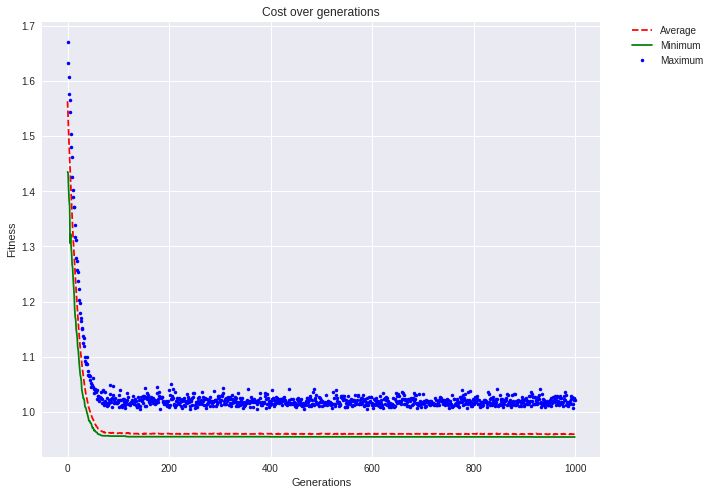

In [16]:
result = []
for fn in fileList:
    result.append(solve(dataDir+fn, POPSIZE, NGEN, CXPB, MUTPB, INVPB, TSIZE))

result = pd.DataFrame(result, columns=['problem', 'cost', '|S|', 'S'])

result.to_csv('HW2Q2results.csv')